In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os

In [5]:
def downsample(image , n, m):
    scaling_factorx = n / image.shape[1]
    scaling_factory = m / image.shape[0]

    resized_image = cv2.resize(image, None, fx=scaling_factorx, fy=scaling_factory , interpolation=cv2.INTER_AREA)

    return resized_image

In [6]:
image1 = cv2.imread('./Images/image1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('./Images/image2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

print(image1.shape,image2.shape)

(219, 327, 3) (460, 736, 3)


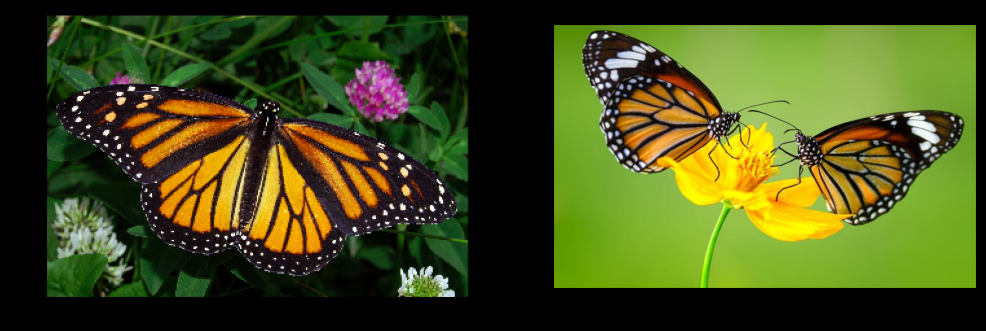

In [7]:
fig = plt.figure(figsize=(12,10),facecolor='black')

fig.add_subplot(1,2,1)
plt.imshow(image1)
fig.add_subplot(1,2,2)
plt.imshow(image2)

plt.show()

### K-Means

In [8]:
def kmeans_segmentation(image_to_be_segmented, k, threshold):
    image = image_to_be_segmented.copy()

    # Converting pixel values to float32
    pixel_values = np.float32(image.reshape((-1,3)))

    # Applying KMeans and getting back tuple of results (float, labels, centers)
    return_val1, labels, centers = cv2.kmeans(data=pixel_values,K=k,bestLabels=None,criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,1000,1-threshold),attempts=10,flags=cv2.KMEANS_RANDOM_CENTERS)

    # Centers have to be of type non negative int
    centers = np.uint8(centers)

    print(labels.shape,centers.shape,return_val1)
    
    segmented_data = centers[labels.flatten()]

    segmented_image = segmented_data.reshape((image.shape))

    return segmented_image

(71613, 1) (3, 3) 187523382.2717514
(338560, 1) (3, 3) 797737886.4601552
(71613, 1) (6, 3) 82107215.68418515
(338560, 1) (6, 3) 309415241.63600034


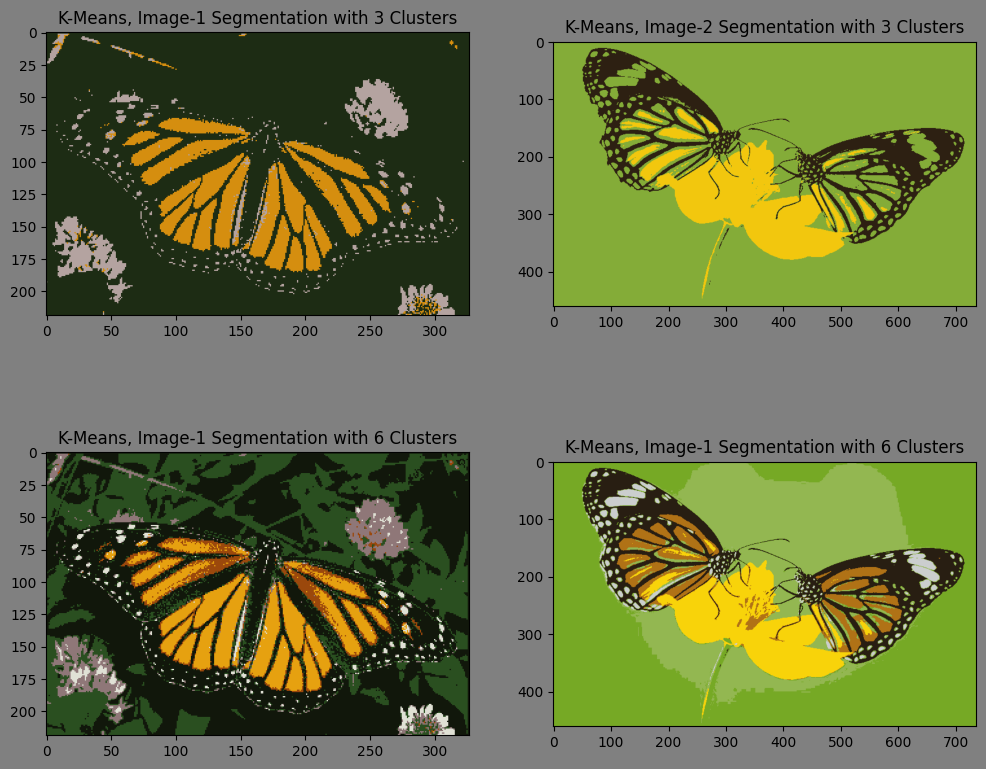

In [9]:
segmented_image1_3_clusters = kmeans_segmentation(image1,3,0.05)
segmented_image2_3_clusters = kmeans_segmentation(image2,3,0.05)

segmented_image1_6_clusters = kmeans_segmentation(image1,6,0.05)
segmented_image2_6_clusters = kmeans_segmentation(image2,6,0.05)

fig = plt.figure(figsize=(12,10),facecolor='gray')

fig.add_subplot(2,2,1)
plt.title('K-Means, Image-1 Segmentation with 3 Clusters')
plt.imshow(segmented_image1_3_clusters)

fig.add_subplot(2,2,2)
plt.title('K-Means, Image-2 Segmentation with 3 Clusters')
plt.imshow(segmented_image2_3_clusters)

fig.add_subplot(2,2,3)
plt.title('K-Means, Image-1 Segmentation with 6 Clusters')
plt.imshow(segmented_image1_6_clusters)

fig.add_subplot(2,2,4)
plt.title('K-Means, Image-1 Segmentation with 6 Clusters')
plt.imshow(segmented_image2_6_clusters)


plt.show()

#### Downsampling Images for Ratio-Cut

In [10]:
image1 = downsample(image1, 64, 64)
image1 = image1.reshape((-1,3))
image2 = downsample(image2, 64, 64)
image2 = image2.reshape((-1,3))

(4096, 3) 3
Calculating Adjacency Matrix W


C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_16640\1366285494.py:13: RuntimeWarning: overflow encountered in scalar subtract
  s_ij += (img[i][k] - img[j][k])**2


Calculating Degree Matrix
Calculating Laplacian Matrix
Calculating EigenValues and EigenVectors
Sorting the EigenValues and EigenVectors to find the lowest K
Calculating H
Applying KMeans to H


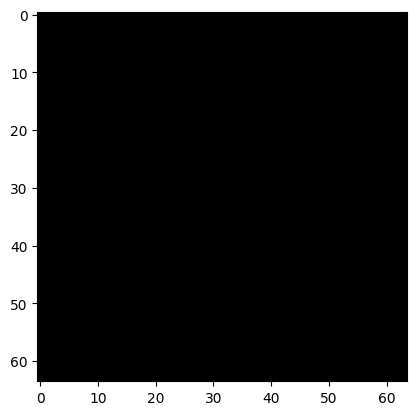

In [72]:
def ratio_cut_clustering(image,k):
    img = image.copy()
    n = img.shape[0]
    
    print("Calculating Adjacency Matrix W")
    W = np.zeros((n,n))

    for i in range(n):
        for j in range(i+1,n):
            s_ij = 0
            for k in range(len(img[i])): # For all components in Colour , R G B
                s_ij += (img[i][k] - img[j][k])**2

            s_ij += ((i-j)//64)**2 # For getting the difference in y axis
            s_ij += ((i-j)%64)**2  # For getting the difference in x axis

            s_ij = s_ij**0.5       # s(i,j) = square_root( (x1-x2)**2 + (y1-y2)**2 + (R1-R2)**2 + (G1-G2)**2 + (B1-B2)**2 )

            W[i][j] = s_ij
        
        for j in range(i):
            W[i][j] = W[j][i]

    W = np.exp(-0.5 * (W/np.std(W))**2)
    for i in range(n):
        W[i][i] = 0

    print("Calculating Degree Matrix")
    D = np.zeros((n,n))
    for i in range(n): D[i][i] = np.sum(W[i])

    print("Calculating Laplacian Matrix")
    L = D - W

    print("Calculating EigenValues and EigenVectors")
    e_val , e_vec = np.linalg.eig(L)

    print("Sorting the EigenValues and EigenVectors to find the lowest K")
    e_pair = sorted( [ [e_val[i],e_vec[i]] for i in range(len(e_val)) ] )
    
    print("Calculating H")
    H = np.array([ e_pair[0][1],e_pair[1][1],e_pair[2][1] ]).T
    H = np.float32(H)

    print("Applying KMeans to H")
    return_val , labels , centers = cv2.kmeans( H , k , None , (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER , 10000 , 1e-15 ) , 10 , cv2.KMEANS_RANDOM_CENTERS )

    centers = np.uint8(centers)
    data = centers[labels.flatten()]
    seg_img = data.reshape((64,64,3))

    return seg_img

plt.imshow(ratio_cut_clustering(image1,3))    